In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import gcf

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [3]:
#load data
#there appears to be an issue with index_col = [0],  header=[0,1]
wt_conn = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv',  header=[0,1])

def fix_pdcsv(csv):
    
    #wt_conn = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv',  header=[0,1])
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

wt_conn = fix_pdcsv(wt_conn)

In [5]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

annotation/ccf_2017


In [6]:
connectivity_data = get_connectivity_data(cache, major_structure_ids[:12], experiments_exclude, remove_injection = False)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs

512
703
1089
1097
315
313
354
698
771
803
477
549


In [7]:
from mcmodels.core import Mask
def get_regional_centroids(cache,sid,hemisphere_id):
    
    mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=hemisphere_id)
    centroid_loc = np.mean(mask.coordinates, axis = 0)
    
    return(centroid_loc)

regional_centroids_sources = np.asarray([get_regional_centroids(cache,ai_map[wt_conn.index[i]],hemisphere_id = 2) for i in range(len(wt_conn.index))])

In [8]:
ipsi_names = np.asarray(list(wt_conn.columns))[:291][:,1]
contra_names = np.asarray(list(wt_conn.columns))[291:][:,1]

In [9]:
regional_centroids_ipsitargets = np.asarray([get_regional_centroids(cache,ai_map[ipsi_names[i]],hemisphere_id = 2) for i in range(291)])
regional_centroids_contratargets = np.asarray([get_regional_centroids(cache,ai_map[contra_names[i]],hemisphere_id = 2) for i in range(286)])


In [10]:
regional_centroids_targets = np.vstack([regional_centroids_ipsitargets,regional_centroids_contratargets])

ntarg = 577
nsource = regional_centroids_sources.shape[0]
distances = np.zeros((nsource, ntarg))
for i in range(nsource):
    #print(i)
    for j in range(ntarg):
        distances[i,j] = np.linalg.norm(regional_centroids_sources[i] - regional_centroids_targets[j])
        


In [284]:
major_ontoloogy = np.load('/Users/samsonkoelle/ontological_order_leaves_majors_names.npy')
#major_ontoloogy_nonzero = np.asarray(major_ontoloogy)[ids]

In [291]:
crow = np.zeros((541,4), dtype  =float)

for i in range(541):
    crow[i,:] = np.asarray(cs_col_ipsi_dict[major_ontoloogy[i]])

In [294]:
# major_labels = row_multi_ind_tuples.get_level_values("Cre")
# major_pal = sns.color_palette("cubehelix", n_colors = major_labels.unique().size)
# major_lut = dict(zip(map(str, major_labels.unique()), cre_pal))
# #major_colors = pd.Series(major_labels, index=row_multi_ind_tuples).map(major_lut)


In [304]:
reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0])

In [306]:
reo

array([ 4,  7,  2,  1, 10,  9, 11,  3,  5,  8,  6,  0])

array(['CB', 'CTXsp', 'HPF', 'HY', 'Isocortex', 'MB', 'MY', 'OLF', 'P',
       'PAL', 'STR', 'TH'], dtype='<U9')

Text(400.0, 0.6, 'Contralateral')

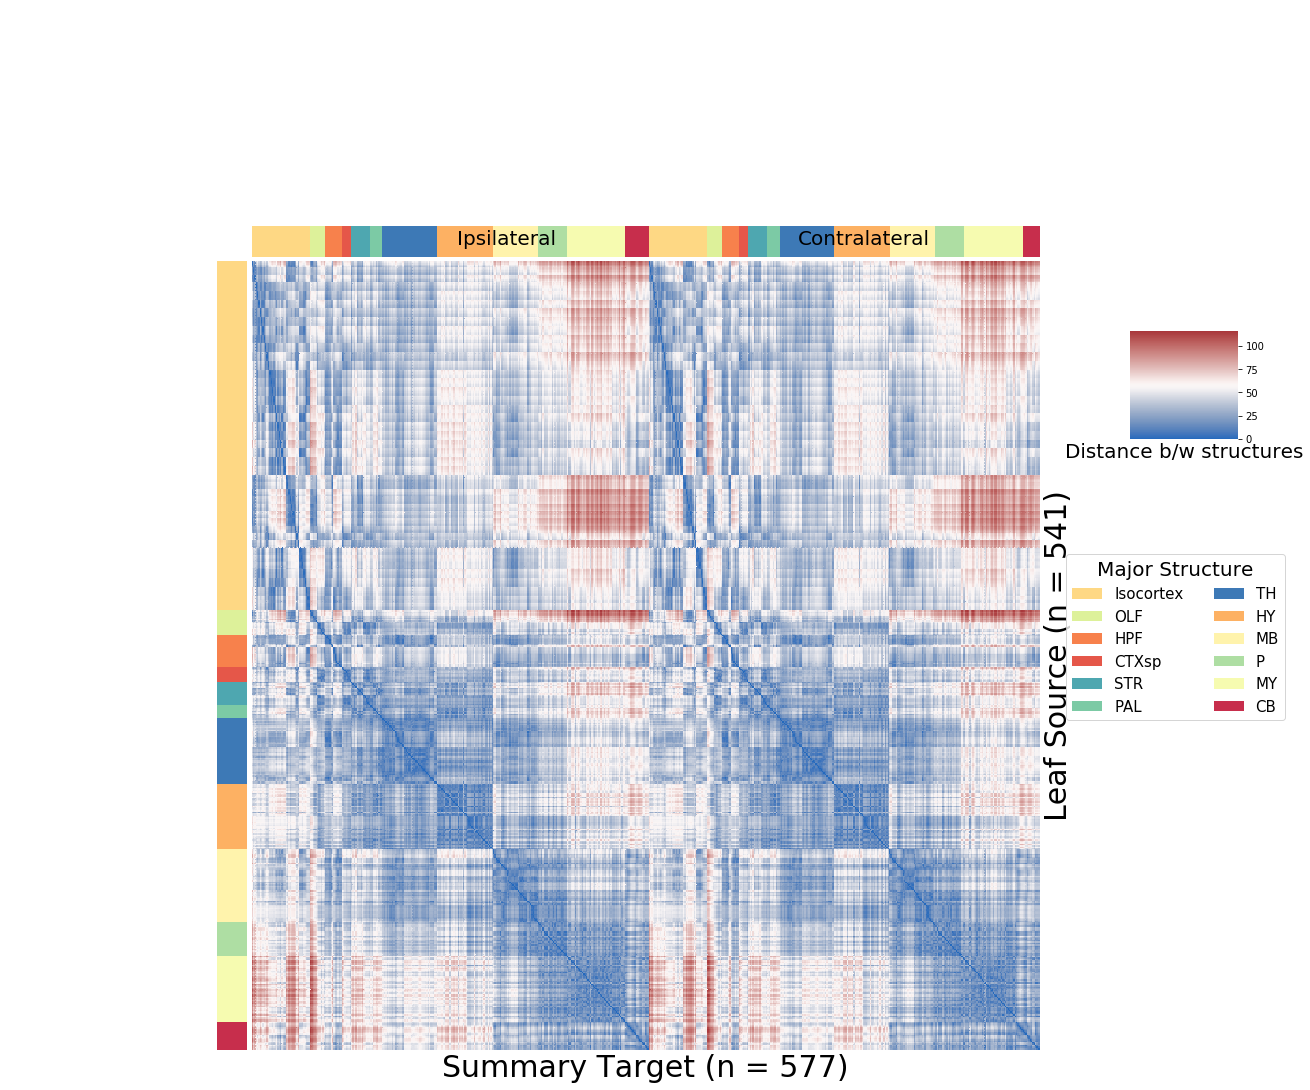

In [375]:
g= sns.clustermap(distances, col_cluster = False, row_cluster = False, col_colors=ccol, 
                  row_colors = crow, figsize = (15,15), cmap = 'vlag')
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xlabel('Summary Target (n = 577)', fontsize = 30)
g.ax_heatmap.set_ylabel('Leaf Source (n = 541)', fontsize = 30)
#g.set_title('Source-target distances', fontsize = 40)
ax = gcf().add_axes((0.6,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=2, bbox_to_anchor=(1.2, .5), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Distance b/w structures', rotation=0, fontsize = 20)
g.ax_cbar.set_position([1.05,0.6,.1,.1])
g.ax_col_colors.text(150.,.6, 'Ipsilateral', fontsize = 20)
g.ax_col_colors.text(400.,.6, 'Contralateral', fontsize = 20)

# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
#plt.savefig('/Users/samsonkoelle/distances.png', bbox_inches = [0,0,1.,1.],
#    pad_inches = 0)

In [367]:
help(plt.savefig)

Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, dpi=None, facecolor='w', edgecolor='w',
              orientation='portrait', papertype=None, format=None,
              transparent=False, bbox_inches=None, pad_inches=0.1,
              frameon=None, metadata=None)
    
    The output formats available depend on the backend being used.
    
    Parameters
    ----------
    
    fname : str or PathLike or file-like object
        A path, or a Python file-like object, or
        possibly some backend-dependent object such as
        `matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is not set, then the output format is inferred from
        the extension of *fname*, if any, and from :rc:`savefig.format`
        otherwise.  If *format* is set, it determines the output format.
    
        Hence, if *fname* is not a path or has no extension, remember to
      

In [326]:
from sklearn.linear_model import LinearRegression

In [334]:
# lr = LinearRegression()
# lr.fit(np.log(distances), np.log(wt_conn))

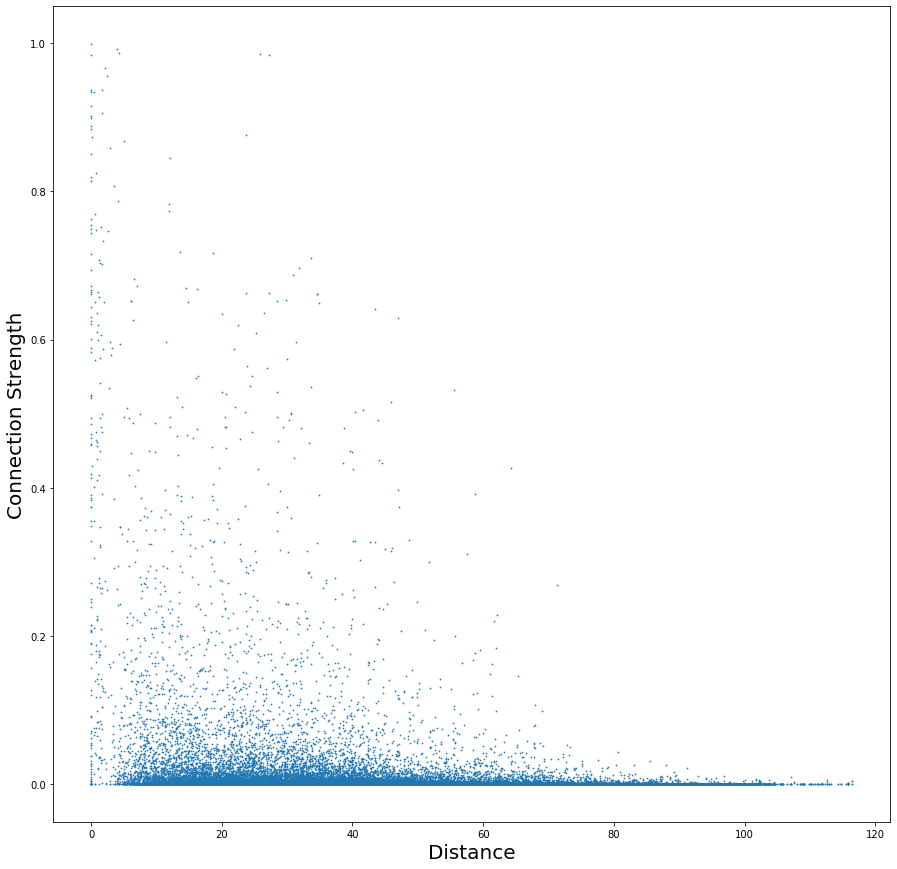

In [356]:
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(distances, wt_conn, s = .5)
ax.set_xlabel('Distance', fontsize = 20)
ax.set_ylabel('Connection Strength', fontsize = 20)
plt.savefig('/Users/samsonkoelle/distance_conn.png', bbox_inches = 'tight',
    pad_inches = 0)

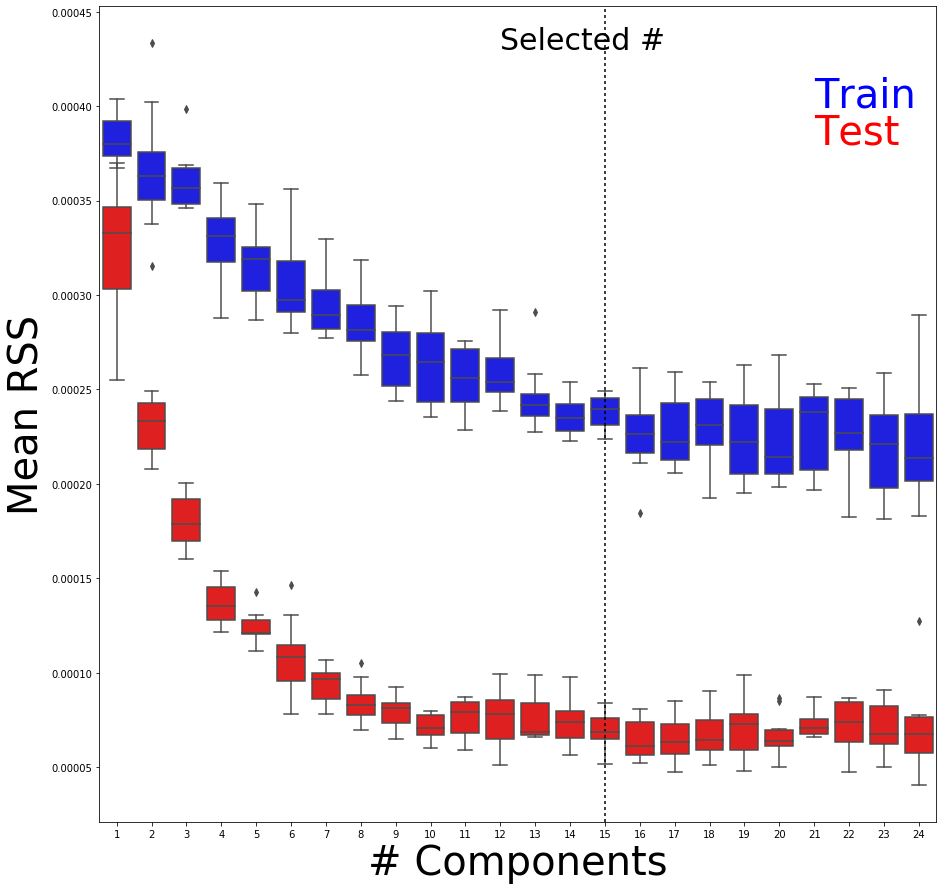

In [357]:
fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = te_results[:,1:], ax=  ax, color= 'blue')
sns.boxplot( data = tr_results[:,1:], ax=  ax, color= 'red')
ax.set_xticklabels(list(range(1,25)))
ax.axvline(14, color='k', dashes=[2,2])
ax.text(20,.0004, 'Train',color = 'blue', fontsize = 40)
ax.text(20,.00038, 'Test',color = 'red', fontsize = 40)
ax.text(11,.00043, 'Selected #', fontsize = 30)
ax.set_ylabel('Mean RSS', fontsize = 40)
ax.set_xlabel('# Components', fontsize = 40)
fig.savefig('/Users/samsonkoelle/test_train.png', bbox_inches = 'tight',
    pad_inches = 0)
#ax.legend()

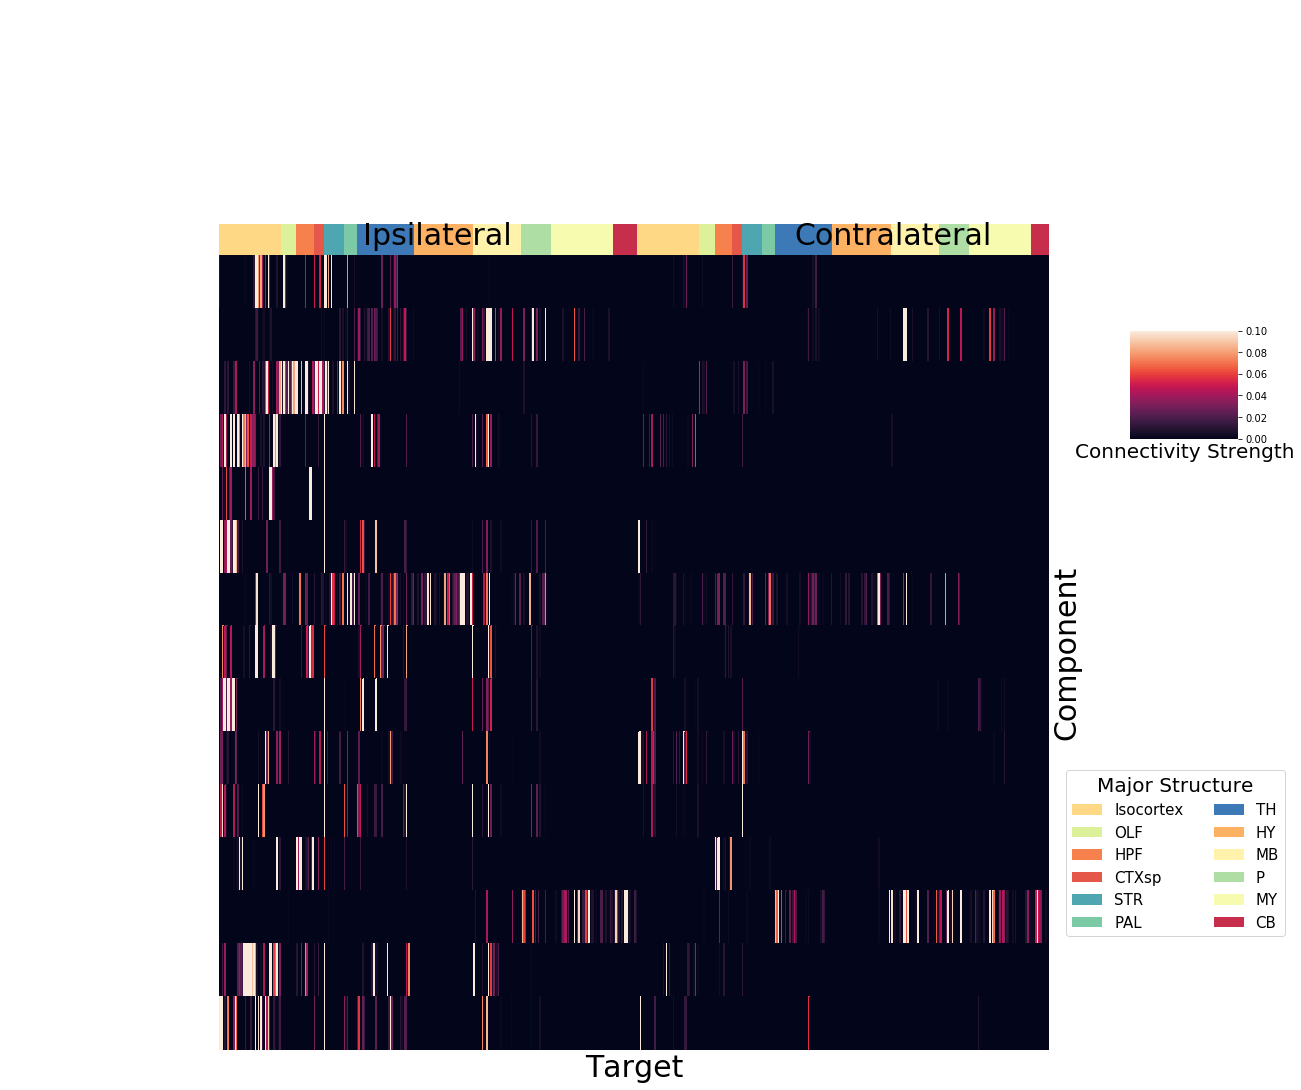

In [394]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(nmf.components_, vmin = 0., vmax = 0.1 , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15))

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Target', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.65, 'Ipsilateral', fontsize = 30)
g.ax_col_colors.text(400.,.65, 'Contralateral', fontsize = 30)

ax = gcf().add_axes((0.74,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=cs_col_ipsi_dict[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=2, bbox_to_anchor=(1.2, .3), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Connectivity Strength', rotation=0, fontsize = 20)
g.ax_cbar.set_position([1.05,0.6,.1,.1])

g.savefig('/Users/samsonkoelle/nmf_heatmap.png', bbox_inches = 'tight',
    pad_inches = 0)

In [359]:
import matplotlib.image as mpimg

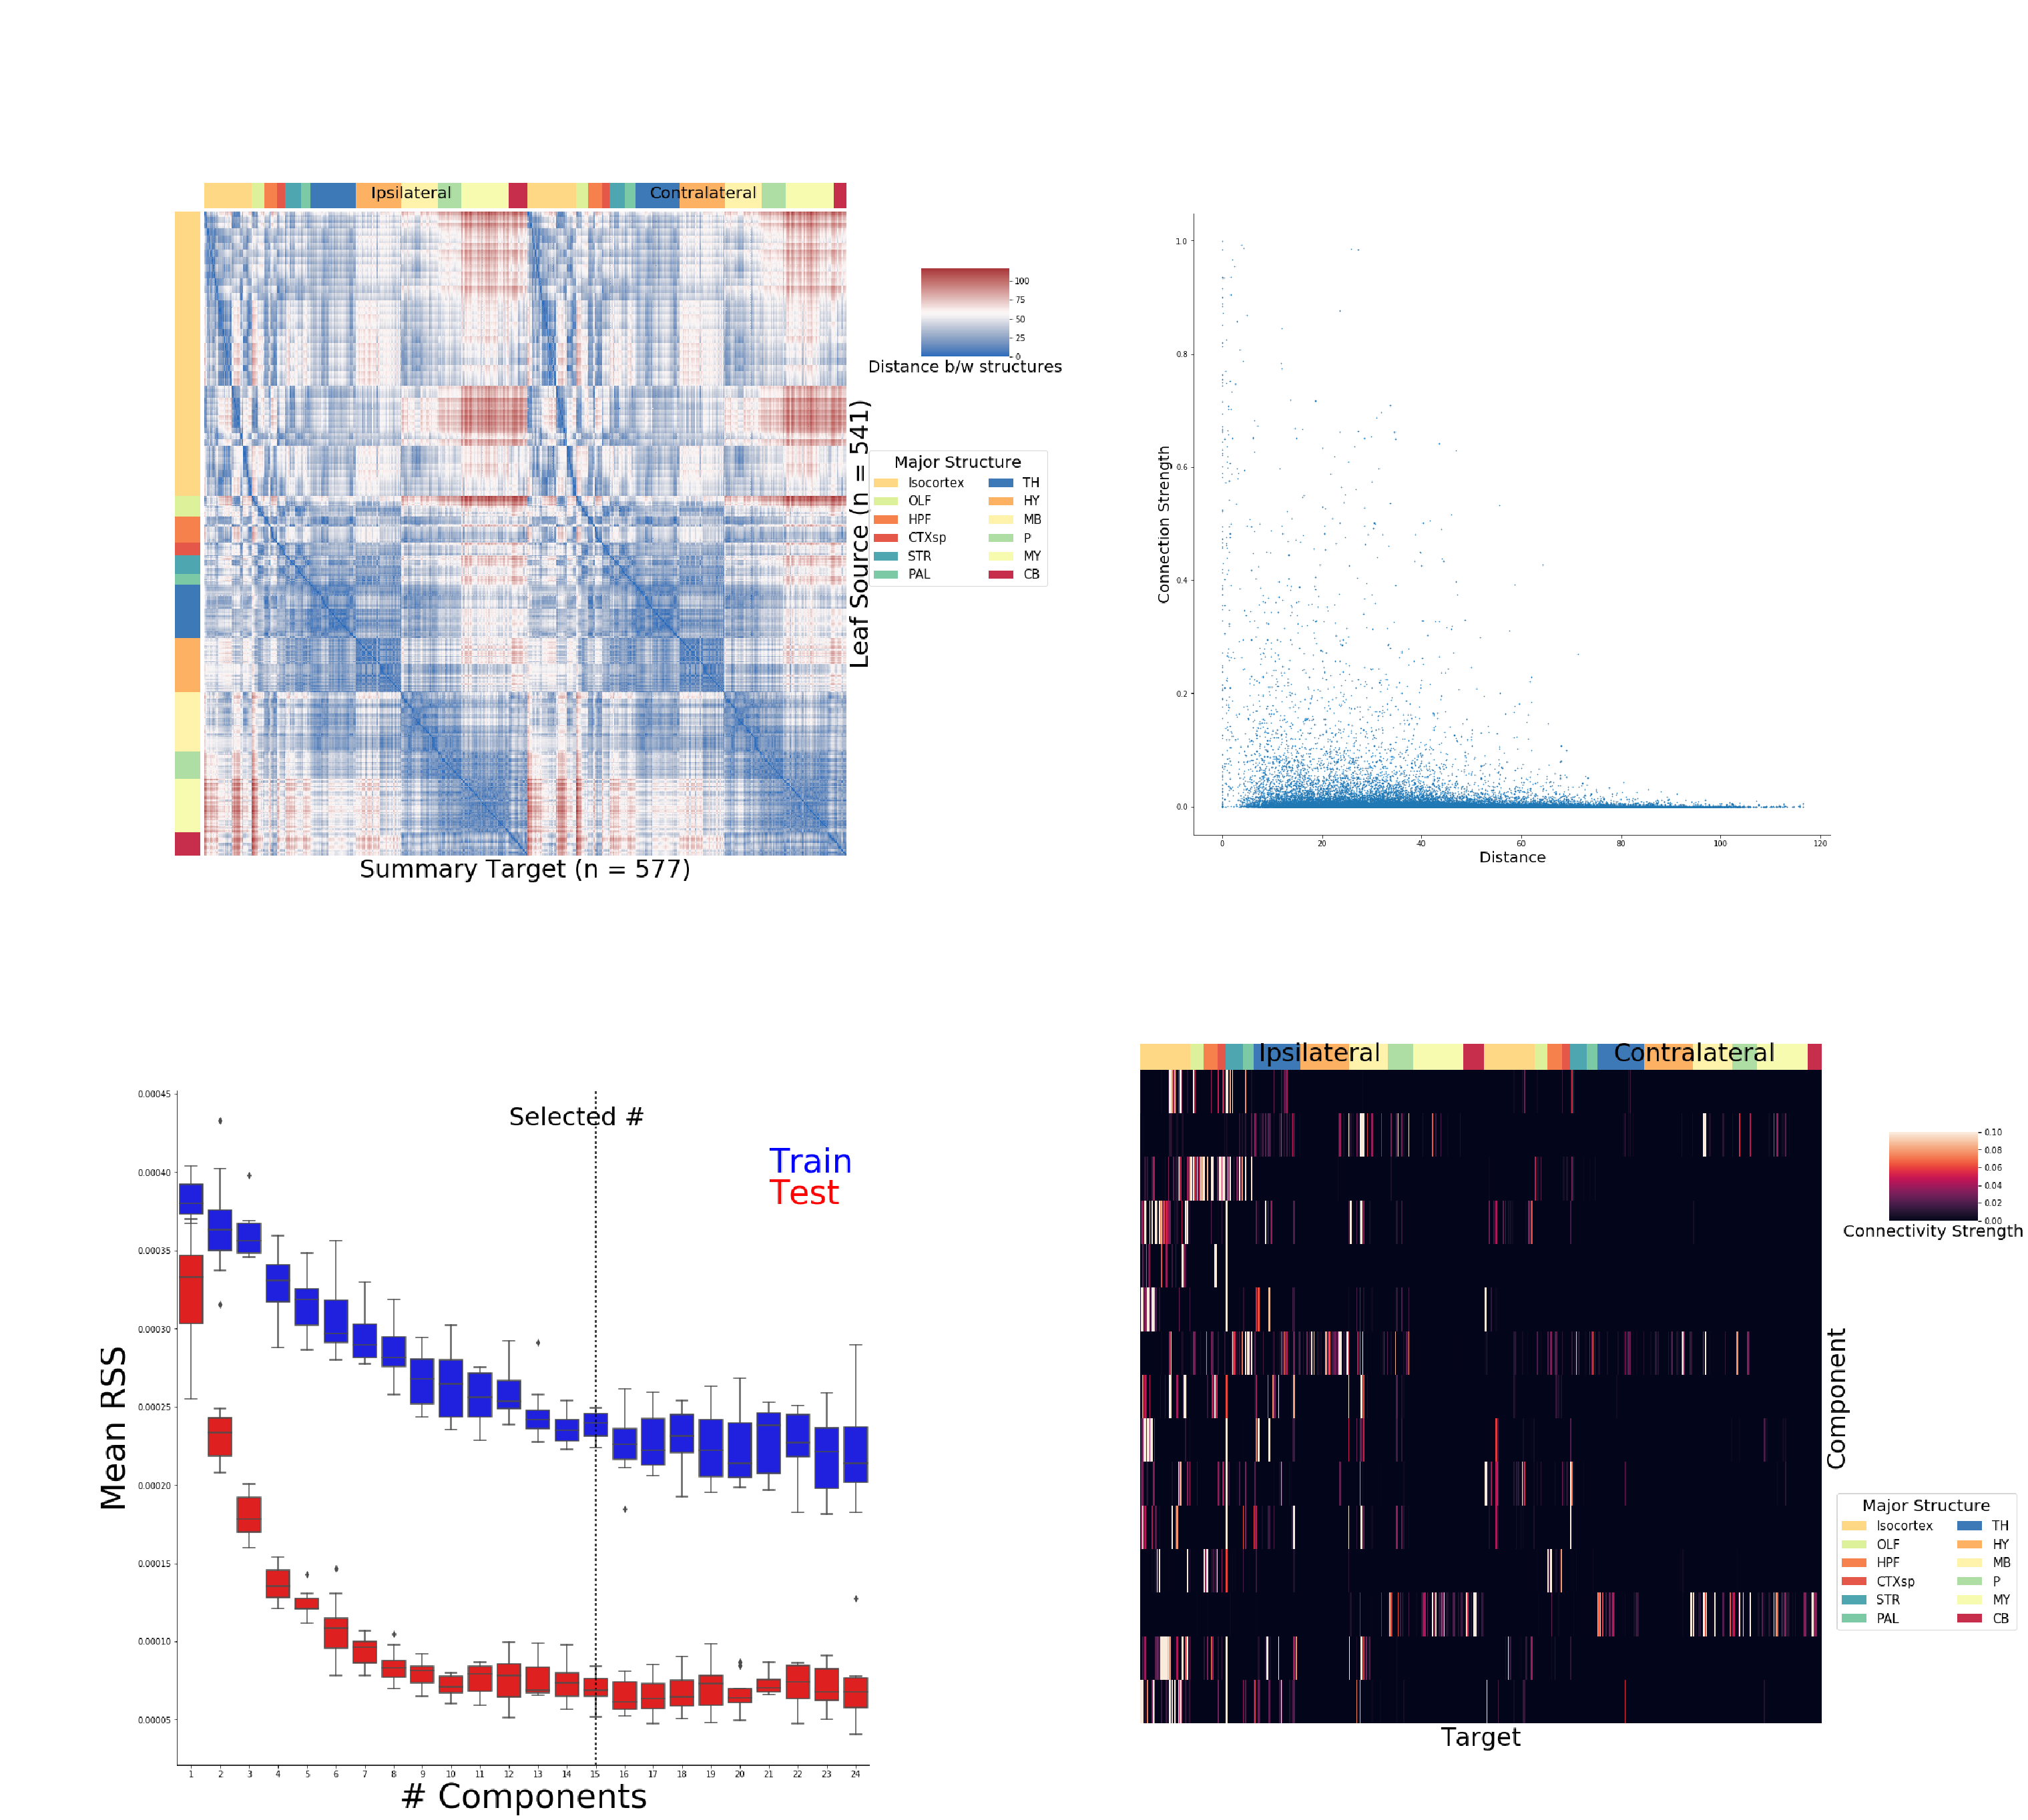

In [399]:
f, axarr = plt.subplots(2, 2, figsize=(40, 40))


axarr[0,0].imshow(mpimg.imread('/Users/samsonkoelle/distances.png'))
axarr[0,1].imshow(mpimg.imread('/Users/samsonkoelle/distance_conn.png'))
axarr[1,0].imshow(mpimg.imread('/Users/samsonkoelle/test_train.png'))
axarr[1,1].imshow(mpimg.imread('/Users/samsonkoelle/nmf_heatmap.png'))


# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]



axarr[0,0].set_position([-.05, 0.45, 0.55,  0.55])
axarr[0,1].set_position([0.55, 0.5, 0.35,  0.35])
axarr[1,0].set_position([0.0, 0., 0.4,  0.4])
axarr[1,1].set_position([0.45, 0., 0.55,  0.55])
# f.axes[1].set_position([0.05, 0.45, 0.4,  0.05])
# f.axes[2].set_position([0.45, 0.05, 0.05, 0.4])
# f.axes[3].set_position([0.55, 0.05, 0.4,  0.4])
# f.axes[4].set_position([0.55, 0.45, 0.4,  0.05])
# f.axes[5].set_position([0.95, 0.05, 0.05, 0.4])


#plt.tight_layout()
plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/Figure5')

In [386]:
help(axarr[0,1].set_position)

Help on method set_position in module matplotlib.axes._base:

set_position(pos, which='both') method of matplotlib.axes._subplots.AxesSubplot instance
    Set the axes position.
    
    Axes have two position attributes. The 'original' position is the
    position allocated for the Axes. The 'active' position is the
    position the Axes is actually drawn at. These positions are usually
    the same unless a fixed aspect is set to the Axes. See `.set_aspect`
    for details.
    
    Parameters
    ----------
    pos : [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
        The new position of the in `.Figure` coordinates.
    
    which : {'both', 'active', 'original'}, optional
        Determines which position variables to change.



/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


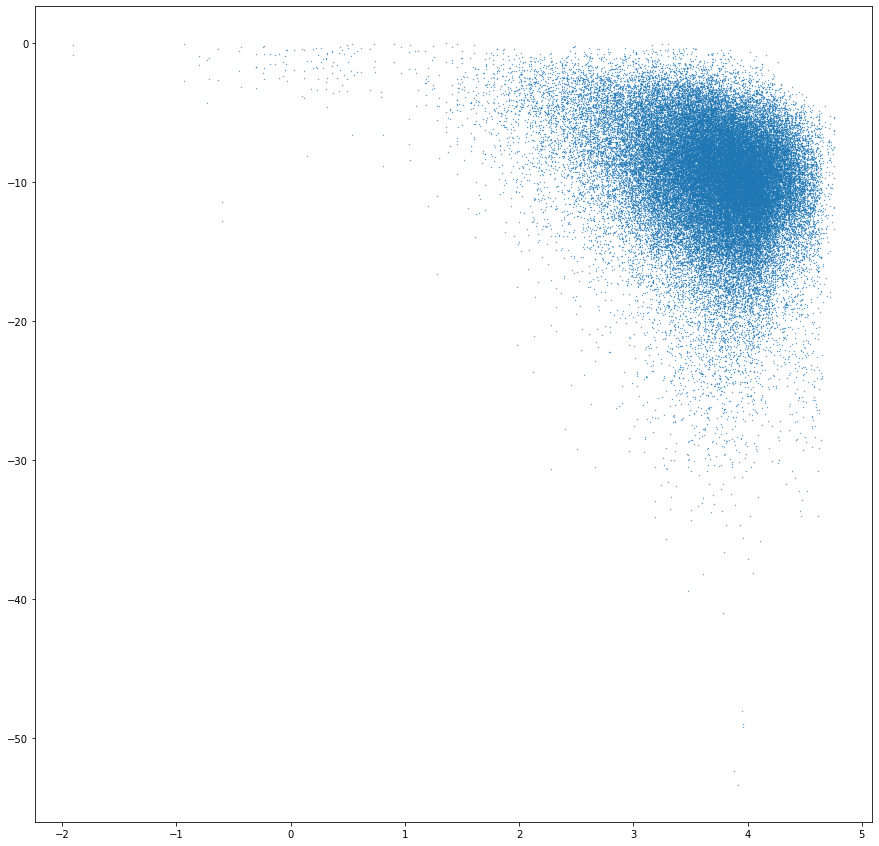

In [323]:
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(np.log(distances), np.log(wt_conn), s = .1)

In [23]:
tonan = np.asarray(np.where(distances < 15)).transpose()
wt_conn_nan = wt_conn.copy()
for i in range(tonan.shape[0]):
    wt_conn_nan.iloc[tonan[i,0],tonan[i,1]] = np.nan

In [25]:
from sklearn.decomposition._nmf import NMF

In [27]:
rss= np.nansum(wt_conn, axis = 1)
ids = np.where(rss > 0.)[0]

In [28]:
nmf_sk = NMF(n_components=10, alpha=0.01, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
nmf_sk.fit(np.asarray(wt_conn_nan)[ids])
tnmf_sk = nmf_sk.transform(np.asarray(wt_conn_nan)[ids])
itnmf_sk = nmf_sk.inverse_transform(tnmf_sk)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(-6, 0)

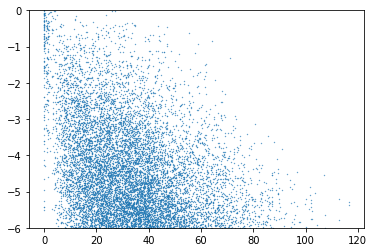

In [12]:
plt.scatter(np.log(distances), np.log(wt_conn), s = .1)
plt.ylim(-6,0)
#plt.savefig('/Users/samsonkoelle/linearr.png')

In [ ]:
plt.scatter(np.log(distances), np.log(wt_conn), s = .1)
plt.ylim(-6,0)
#plt.savefig('/Users/samsonkoelle/linearr.png')

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


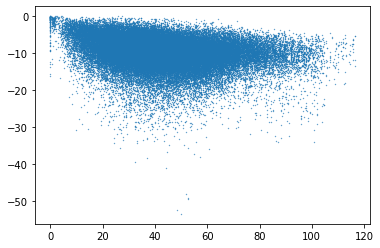

In [191]:
plt.scatter(distances, np.log(wt_conn), s = .1)
plt.savefig('/Users/samsonkoelle/linearr.png')

In [56]:
tonan = np.asarray(np.where(distances < 15)).transpose()
wt_conn_nan = wt_conn.copy()
for i in range(tonan.shape[0]):
    wt_conn_nan.iloc[tonan[i,0],tonan[i,1]] = np.nan
    
data = np.asarray(wt_conn_nan)

In [122]:
def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.,p_holdout = .3):
    
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    
    return(tr_err, te_err)

In [141]:
train_err = []
test_err = []
nrep = 10
tr_results = np.zeros((nrep,25))
te_results = np.zeros((nrep,25))
for n in range(1,25):
    print(n)
    for r in range(nrep):
        #n_components = n
        tr_results[r,n] , te_results[r,n] = cv_nmf_missing(data, n_components = n ,alpha=0.01, l1_ratio = 1.,p_holdout = .3)
        #train_err.append( tr)
        #test_err.append( te)
    

1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

3


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

5


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

7


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

8


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

9


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

12


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

13


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

14


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

15


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

16


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

17


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

18


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

19


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

20


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

21


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

22


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

23


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

24


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

In [183]:
# te_results_pd = pd.DataFrame(te_results)
# te_results_pd.columns = list(range(25))

Text(0.5, 0, '# Components')

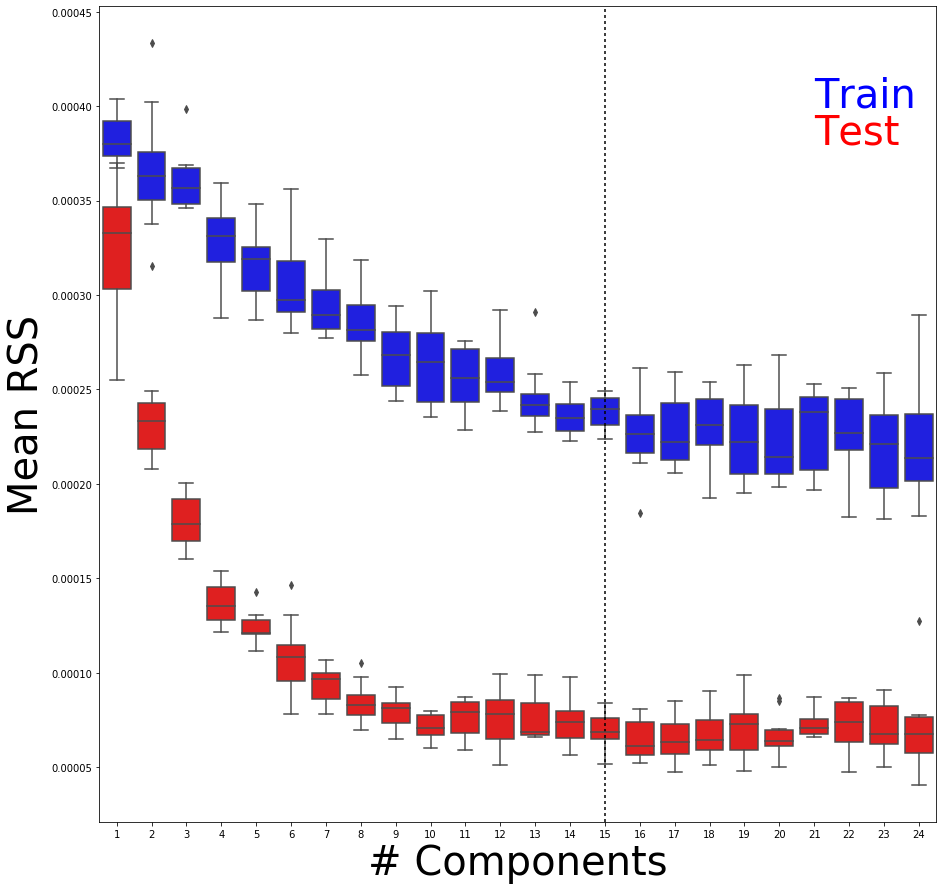

In [239]:
fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = te_results[:,1:], ax=  ax, color= 'blue')
sns.boxplot( data = tr_results[:,1:], ax=  ax, color= 'red')
ax.set_xticklabels(list(range(1,25)))
ax.axvline(14, color='k', dashes=[2,2])
ax.text(20,.0004, 'Train',color = 'blue', fontsize = 40)
ax.text(20,.00038, 'Test',color = 'red', fontsize = 40)
ax.set_ylabel('Mean RSS', fontsize = 40)
ax.set_xlabel('# Components', fontsize = 40)
fig.savefig('/Users/samsonkoelle/test_train.png')
#ax.legend()

In [180]:
nmf = NMF(n_components=15, alpha=.01, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
nmf.fit(data)
tnmf_sk = nmf.transform(np.asarray(data))
itnmf_sk = nmf.inverse_transform(tnmf_sk)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


NMF(alpha=0.01, beta_loss='frobenius', init='random', l1_ratio=1.0,
    max_iter=500, n_components=15, random_state=None, shuffle=False,
    solver='mu', tol=0.0001, verbose=0)

In [210]:
major_ontoloogy_summary = np.load('/Users/samsonkoelle/ontological_order_summary_majors_names.npy')

In [211]:
cs_col_ipsi = sns.color_palette("Spectral", 12)
cs_col_contra = sns.color_palette("Spectral", 12)

alphad_ipsi_majors = np.hstack([np.asarray(cs_col_contra), np.expand_dims(np.ones(12),1)])
alphad_contra_majors = np.hstack([np.asarray(cs_col_contra), .02*np.expand_dims(np.ones(12),1)])

cs_col_ipsi = alphad_ipsi_majors
cs_col_contra = alphad_contra_majors

cs_col_ipsi_dict = {}
cs_col_contra_dict = {}
for i in range(12):
    cs_col_ipsi_dict[major_structures[i]] = cs_col_ipsi[i]
    cs_col_contra_dict[major_structures[i]] = cs_col_contra[i]

ccol = np.zeros((577,4), dtype  =float)

for i in range(291):
    ccol[i,:] = np.asarray(cs_col_ipsi_dict[major_ontoloogy_summary[i]])
    
for i in range(286):
    ccol[i+ 291] = np.asarray(cs_col_contra_dict[major_ontoloogy_summary[:286][i]])
    

Text(400.0, 0.6, 'Contralateral')

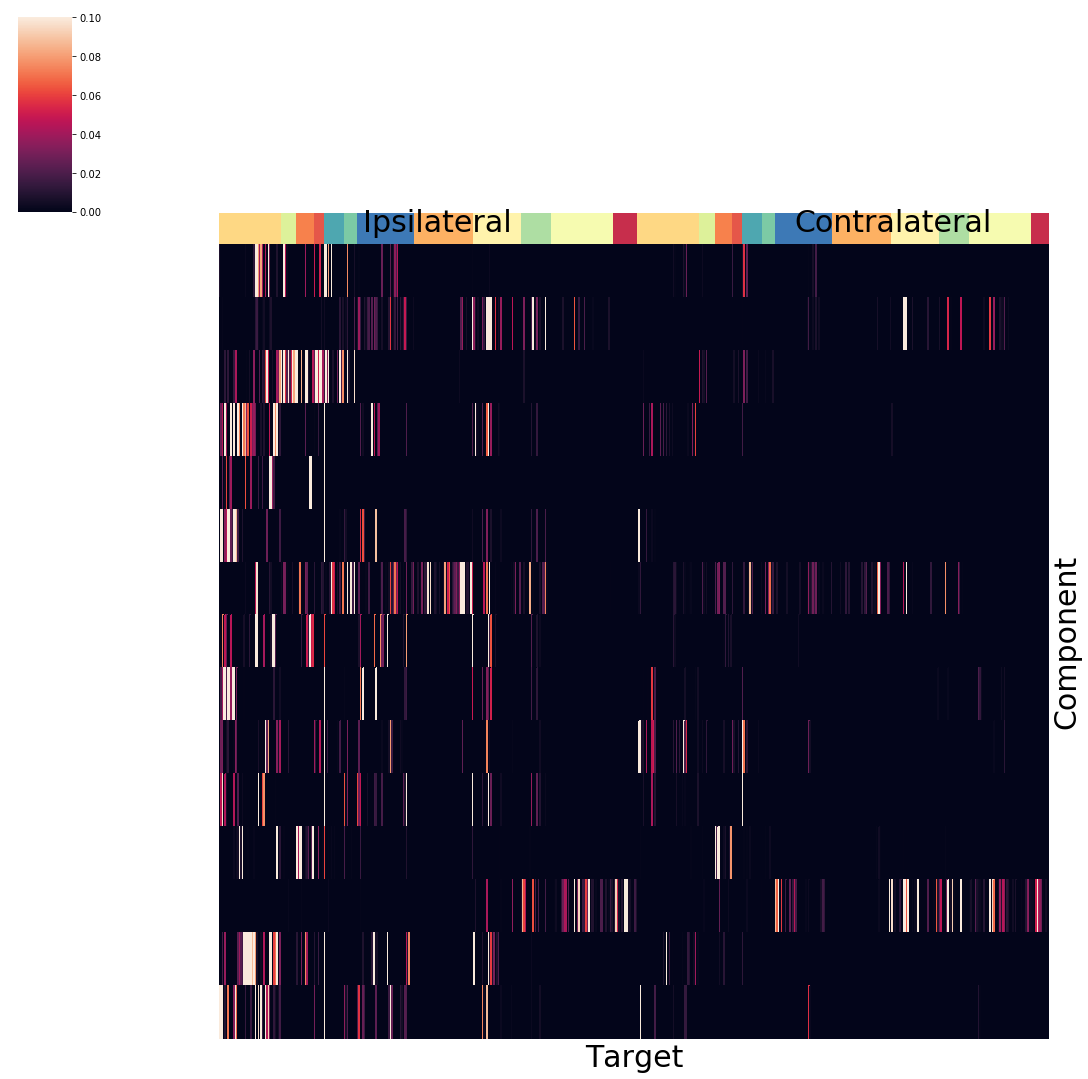

In [226]:
#fig plt.figure(figsize = (15,15))
g = sns.clustermap(nmf.components_, vmin = 0., vmax = 0.1 , col_colors=ccol,
                    row_cluster=False , 
                    col_cluster = False, figsize = (15,15))

#g.ax_col_colors.text(250.,-.75, 'Target', fontsize = 70)
#g.ax_row_colors.text(-2.,65., 'Component', fontsize = 70, rotation = 90)
g.ax_heatmap.set_ylabel('Component', fontsize = 30)
g.ax_heatmap.set_xlabel('Target', fontsize = 30)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_col_colors.text(100.,.6, 'Ipsilateral', fontsize = 30)
g.ax_col_colors.text(400.,.6, 'Contralateral', fontsize = 30)
g.savefig('/Users/samsonkoelle/nmf_heatmap.png')

ValueError: The Subplot must have been created in the present figure

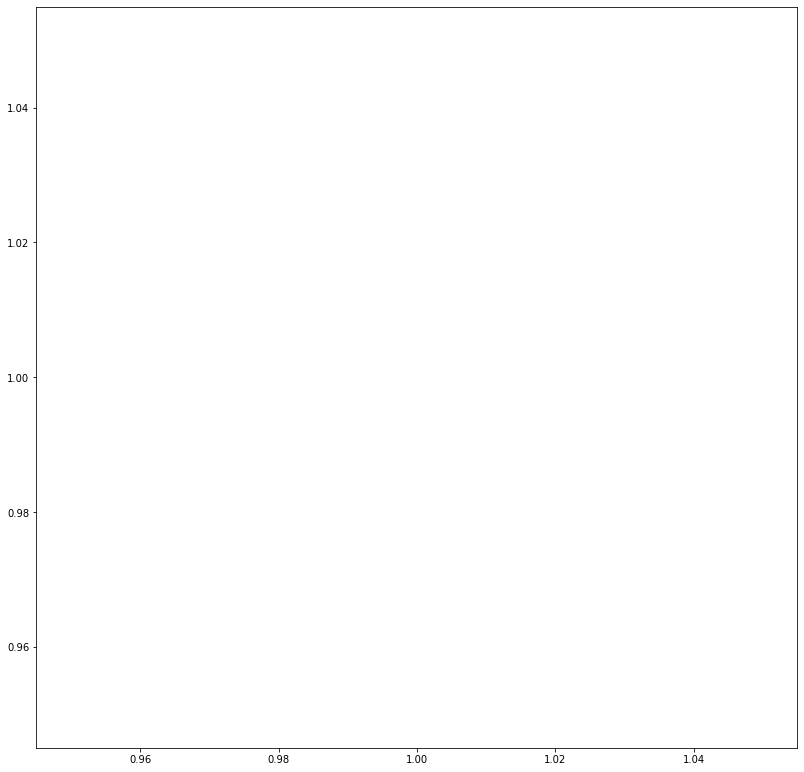

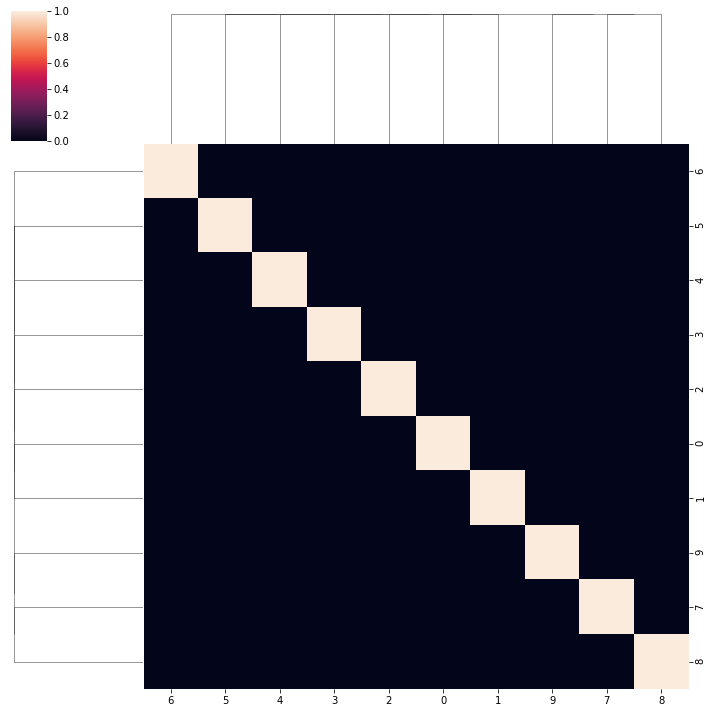

In [258]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1)

#fig.add_subplot(ax)

i = 1
#ax = plt.Subplot(fig, outer[i], projection='3d')
ax = fig.add_subplot(2, 2, 1)
ax.plot(np.ones(100),np.ones(100))
fig.add_subplot(ax)
#fig.add_subplot(ax)
i = 2
g= sns.clustermap(np.identity(10))
ax = plt.Subplot(g.fig, outer[i])
#ax.show()
#g= sns.clustermap(np.identity(10))
#ax.plot(np.ones(100),np.ones(100))
#fig.add_subplot(g.fig)
#fig.add_subplot(ax)


#fig.tight_layout()
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
#plt.tight_layout()
fig.show()

In [262]:
type(g.fig)

matplotlib.figure.Figure

In [264]:
help(plt.Subplot)

Help on class AxesSubplot in module matplotlib.axes._subplots:

class AxesSubplot(SubplotBase, matplotlib.axes._axes.Axes)
 |  AxesSubplot(fig, *args, **kwargs)
 |  
 |  Base class for subplots, which are :class:`Axes` instances with
 |  additional methods to facilitate generating and manipulating a set
 |  of :class:`Axes` within a figure.
 |  
 |  Method resolution order:
 |      AxesSubplot
 |      SubplotBase
 |      matplotlib.axes._axes.Axes
 |      matplotlib.axes._base._AxesBase
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods inherited from SubplotBase:
 |  
 |  __init__(self, fig, *args, **kwargs)
 |      *fig* is a :class:`matplotlib.figure.Figure` instance.
 |      
 |      *args* is the tuple (*numRows*, *numCols*, *plotNum*), where
 |      the array of subplots in the figure has dimensions *numRows*,
 |      *numCols*, and where *plotNum* is the number of the subplot
 |      being created.  *plotNum* starts at 1 in the upper left
 |      corner an

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# data
iris = sns.load_dataset("iris")
tips = sns.load_dataset("tips")

############### 1. CREATE PLOTS
# An lmplot
g0 = sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips, 
                palette=dict(Yes="g", No="m"))
# A PairGrid
g1 = sns.PairGrid(iris, hue="species")
g1.map(plt.scatter, s=5)
# A FacetGrid
g2 = sns.FacetGrid(tips, col="time",  hue="smoker")
g2.map(plt.scatter, "total_bill", "tip", edgecolor="w")
# A JointGrid
g3 = sns.jointplot("sepal_width", "petal_length", data=iris,
                   kind="kde", space=0, color="g")

############### 2. SAVE PLOTS IN MEMORY TEMPORALLY
g0.savefig('g0.png')
plt.close(g0.fig)

g1.savefig('g1.png')
plt.close(g1.fig)

g2.savefig('g2.png')
plt.close(g2.fig)

g3.savefig('g3.png')
plt.close(g3.fig)

############### 3. CREATE YOUR SUBPLOTS FROM TEMPORAL IMAGES
f, axarr = plt.subplots(2, 2, figsize=(25, 16))

axarr[0,0].imshow(mpimg.imread('g0.png'))
axarr[0,1].imshow(mpimg.imread('g1.png'))
axarr[1,0].imshow(mpimg.imread('g3.png'))
axarr[1,1].imshow(mpimg.imread('g2.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()

In [263]:
plt.Subplot(g, outer[i])

AttributeError: 'ClusterGrid' object has no attribute 'subplotpars'

In [254]:
help(plt.Subplot)

Help on class AxesSubplot in module matplotlib.axes._subplots:

class AxesSubplot(SubplotBase, matplotlib.axes._axes.Axes)
 |  AxesSubplot(fig, *args, **kwargs)
 |  
 |  Base class for subplots, which are :class:`Axes` instances with
 |  additional methods to facilitate generating and manipulating a set
 |  of :class:`Axes` within a figure.
 |  
 |  Method resolution order:
 |      AxesSubplot
 |      SubplotBase
 |      matplotlib.axes._axes.Axes
 |      matplotlib.axes._base._AxesBase
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods inherited from SubplotBase:
 |  
 |  __init__(self, fig, *args, **kwargs)
 |      *fig* is a :class:`matplotlib.figure.Figure` instance.
 |      
 |      *args* is the tuple (*numRows*, *numCols*, *plotNum*), where
 |      the array of subplots in the figure has dimensions *numRows*,
 |      *numCols*, and where *plotNum* is the number of the subplot
 |      being created.  *plotNum* starts at 1 in the upper left
 |      corner an

In [253]:
type(g.fig)

matplotlib.figure.Figure

In [ ]:
g.ax_heatmap.set_xticks

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


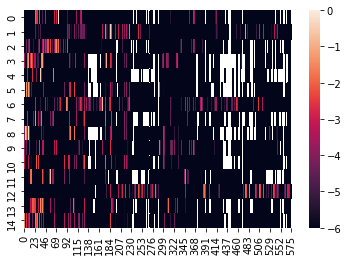

In [203]:
sns.heatmap(np.log(nmf.components_), vmin = -6, vmax = 0.)

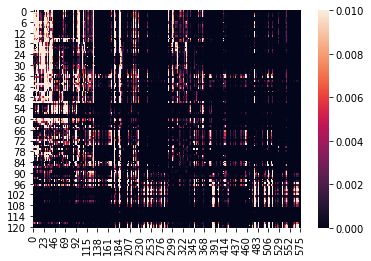

In [195]:
sns.heatmap(itnmf_sk[ids], vmin = 0, vmax = .01)

In [198]:
np.nanmean((itnmf_sk[ids] - data[ids])**2)

0.00010798577016266063

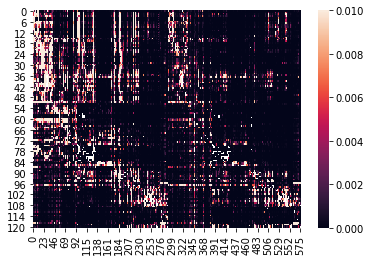

In [196]:
sns.heatmap(data[ids], vmin = 0, vmax = .01)

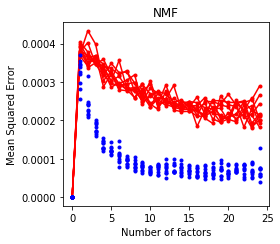

In [160]:
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
    ax.plot(te_results.transpose(), '.-r', label='Train Data')
    ax.plot(tr_results.transpose(), '.b', label='Test Data')
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Number of factors')
    ax.set_title('NMF')
    #ax.axvline(4, color='k', dashes=[2,2])
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.legend()
    fig.tight_layout()

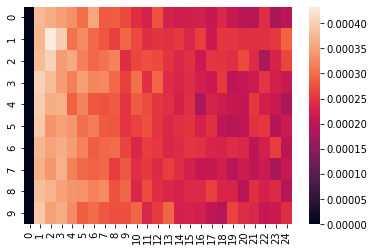

In [142]:
sns.heatmap(te_results)

In [137]:
np.mean(te_results, axis = 0)

array([0.        , 0.00040475, 0.00037436, 0.00036264, 0.00033803,
       0.00033404, 0.00030402, 0.00028134, 0.00029419, 0.00028161,
       0.00026905, 0.00026598, 0.00025049, 0.00024635, 0.00023582])

In [138]:
np.mean(tr_results, axis = 0)

array([0.00000000e+00, 3.11005071e-04, 2.14472111e-04, 1.83418816e-04,
       1.52856508e-04, 1.13551406e-04, 1.01996009e-04, 9.47197852e-05,
       9.00234940e-05, 8.65405456e-05, 8.49874491e-05, 7.39540735e-05,
       6.83649444e-05, 7.85902105e-05, 6.26320527e-05])

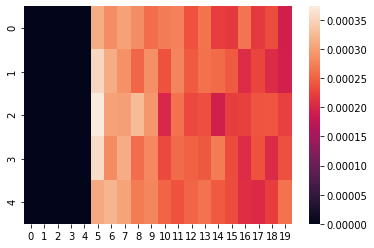

In [131]:
sns.heatmap(te_results)

In [127]:
train_err, test_err

([0.00011286630762710237,
  0.00010540334199141194,
  9.025308780115382e-05,
  8.491116038205628e-05,
  8.348678591360506e-05],
 [0.0003200895913305644,
  0.00031497946762414265,
  0.00028613031207781075,
  0.00031353738062203857,
  0.0002802792311088719])

In [71]:
np.random.rand(presents.shape[0])

array([0.27059702, 0.15486619])

In [67]:
presents

(array([  2,   2,   2, ..., 539, 539, 539]),
 array([  1,   3,   4, ..., 569, 572, 573]))

In [114]:
n_components = 5
alpha = .01
l1_ratio = 1.
missings = np.asarray(np.where(np.isnan(data))).transpose()
presents = np.asarray(np.where(~np.isnan(data))).transpose()

M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

data_tr = data.copy()
for i in range(len(M)):
    data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan
    
data_te = data.copy()
for i in range(len(N)):
    data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

nmf.fit(data_tr)

tr_nmf_embedding = nmf.transform(data_tr)
te_nmf_embedding = nmf.transform(data_te)

tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
te_err= np.nanmean((data_te - te_nmf_recon)**2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [116]:
tr_err, te_err

(0.00021902623593628373, 0.0005586969193030506)

In [98]:
data_nan = data.copy()

In [105]:
data_nan[presents[:,M].transpose()]

IndexError: index 541 is out of bounds for axis 0 with size 541

In [99]:
data_nan[M]  =np.nan

IndexError: index 541 is out of bounds for axis 0 with size 541

In [97]:
presents[:,M[0:2]]

array([[2, 2],
       [1, 3]])

In [95]:
data[presents[:,M[0:2]]]

array([[[           nan, 1.29807511e-01,            nan, ...,
         2.01877531e-07, 1.63880254e-06, 3.22602822e-08],
        [           nan, 1.29807511e-01,            nan, ...,
         2.01877531e-07, 1.63880254e-06, 3.22602822e-08]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])

In [84]:
presents.shape

(2, 66583)

In [77]:
M.shape

(66583,)

In [69]:
presents

array([[  2,   2,   2, ..., 539, 539, 539],
       [  1,   3,   4, ..., 569, 572, 573]])

In [63]:
p_holdout = .1
M = np.random.rand(*wt_conn.shape) > p_holdout

In [64]:
M

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True]])

In [ ]:
for rnk, _ in itertools.product(ranks, range(replicates)):
    tr, te = cv_nmf_missing(np.asarray(wt_conn_nan), rnk)

In [52]:
    replicates = 1
    ranks = np.arange(1, 8)
    train_err, test_err = [], []
    for rnk, _ in itertools.product(ranks, range(replicates)):
        tr, te = cv_pca(np.asarray(wt_conn_nan), rnk, nonneg=True)[2:]
        train_err.append((rnk, tr))
        test_err.append((rnk, te))


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in less


In [ ]:
M=None

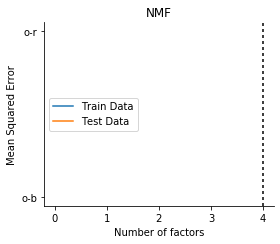

In [143]:
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
    ax.plot(*list(zip(*train_err)), 'o-b', label='Train Data')
    ax.plot(*list(zip(*test_err)), 'o-r', label='Test Data')
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Number of factors')
    ax.set_title('NMF')
    ax.axvline(4, color='k', dashes=[2,2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    fig.tight_layout()

In [227]:
# """
# Code for nonnegative least squares by block-pivoting.
# """
# import numpy as np
# import scipy.optimize as opt
# import scipy.sparse as sps
# import numpy.linalg as nla
# import scipy.linalg as sla
# import time

# """
# The remaining code in this file was written and shared by Jingu Kim (@kimjingu).
# REPO:
# ----
# https://github.com/kimjingu/nonnegfac-python
# LICENSE:
# -------
# Copyright (c) 2014, Nokia Corporation
# All rights reserved.
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above copyright
#       notice, this list of conditions and the following disclaimer in the
#       documentation and/or other materials provided with the distribution.
#     * Neither the name of the Nokia Corporation nor the
#       names of its contributors may be used to endorse or promote products
#       derived from this software without specific prior written permission.
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL NOKIA CORPORATION BE LIABLE FOR ANY
# DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
# ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
# """

# def nnlsm_blockpivot(A, B, is_input_prod=False, init=None):
#     """ Nonnegativity-constrained least squares with block principal pivoting method and column grouping
#     Solves min ||AX-B||_2^2 s.t. X >= 0 element-wise.
#     J. Kim and H. Park, Fast nonnegative matrix factorization: An active-set-like method and comparisons,
#     SIAM Journal on Scientific Computing, 
#     vol. 33, no. 6, pp. 3261-3281, 2011.
#     Parameters
#     ----------
#     A : numpy.array, shape (m,n)
#     B : numpy.array or scipy.sparse matrix, shape (m,k)
#     Optional Parameters
#     -------------------
#     is_input_prod : True/False. -  If True, the A and B arguments are interpreted as
#             AtA and AtB, respectively. Default is False.
#     init: numpy.array, shape (n,k). - If provided, init is used as an initial value for the algorithm.
#             Default is None.
#     Returns
#     -------
#     X, (success, Y, num_cholesky, num_eq, num_backup)
#     X : numpy.array, shape (n,k) - solution
#     success : True/False - True if the solution is found. False if the algorithm did not terminate
#             due to numerical errors.
#     Y : numpy.array, shape (n,k) - Y = A.T * A * X - A.T * B
#     num_cholesky : int - the number of Cholesky factorizations needed
#     num_eq : int - the number of linear systems of equations needed to be solved
#     num_backup: int - the number of appearances of the back-up rule. See SISC paper for details.
#     """
#     if is_input_prod:
#         AtA = A
#         AtB = B
#     else:
#         AtA = A.T.dot(A)
#         if sps.issparse(B):
#             AtB = B.T.dot(A)
#             AtB = AtB.T
#         else:
#             AtB = A.T.dot(B)

#     (n, k) = AtB.shape
#     MAX_ITER = n * 5

#     if init is not None:
#         PassSet = init > 0
#         X, num_cholesky, num_eq = normal_eq_comb(AtA, AtB, PassSet)
#         Y = AtA.dot(X) - AtB
#     else:
#         X = np.zeros([n, k])
#         Y = -AtB
#         PassSet = np.zeros([n, k], dtype=bool)
#         num_cholesky = 0
#         num_eq = 0

#     p_bar = 3
#     p_vec = np.zeros([k])
#     p_vec[:] = p_bar
#     ninf_vec = np.zeros([k])
#     ninf_vec[:] = n + 1
#     not_opt_set = np.logical_and(Y < 0, ~PassSet)
#     infea_set = np.logical_and(X < 0, PassSet)

#     not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
#     not_opt_colset = not_good > 0
#     not_opt_cols = not_opt_colset.nonzero()[0]

#     big_iter = 0
#     num_backup = 0
#     success = True
#     while not_opt_cols.size > 0:
#         big_iter += 1
#         if MAX_ITER > 0 and big_iter > MAX_ITER:
#             success = False
#             break

#         cols_set1 = np.logical_and(not_opt_colset, not_good < ninf_vec)
#         temp1 = np.logical_and(not_opt_colset, not_good >= ninf_vec)
#         temp2 = p_vec >= 1
#         cols_set2 = np.logical_and(temp1, temp2)
#         cols_set3 = np.logical_and(temp1, ~temp2)

#         cols1 = cols_set1.nonzero()[0]
#         cols2 = cols_set2.nonzero()[0]
#         cols3 = cols_set3.nonzero()[0]

#         if cols1.size > 0:
#             p_vec[cols1] = p_bar
#             ninf_vec[cols1] = not_good[cols1]
#             true_set = np.logical_and(not_opt_set, np.tile(cols_set1, (n, 1)))
#             false_set = np.logical_and(infea_set, np.tile(cols_set1, (n, 1)))
#             PassSet[true_set] = True
#             PassSet[false_set] = False
#         if cols2.size > 0:
#             p_vec[cols2] = p_vec[cols2] - 1
#             temp_tile = np.tile(cols_set2, (n, 1))
#             true_set = np.logical_and(not_opt_set, temp_tile)
#             false_set = np.logical_and(infea_set, temp_tile)
#             PassSet[true_set] = True
#             PassSet[false_set] = False
#         if cols3.size > 0:
#             for col in cols3:
#                 candi_set = np.logical_or(
#                     not_opt_set[:, col], infea_set[:, col])
#                 to_change = np.max(candi_set.nonzero()[0])
#                 PassSet[to_change, col] = ~PassSet[to_change, col]
#                 num_backup += 1

#         (X[:, not_opt_cols], temp_cholesky, temp_eq) = normal_eq_comb(
#             AtA, AtB[:, not_opt_cols], PassSet[:, not_opt_cols])
#         num_cholesky += temp_cholesky
#         num_eq += temp_eq
#         X[abs(X) < 1e-12] = 0
#         Y[:, not_opt_cols] = AtA.dot(X[:, not_opt_cols]) - AtB[:, not_opt_cols]
#         Y[abs(Y) < 1e-12] = 0

#         not_opt_mask = np.tile(not_opt_colset, (n, 1))
#         not_opt_set = np.logical_and(
#             np.logical_and(not_opt_mask, Y < 0), ~PassSet)
#         infea_set = np.logical_and(
#             np.logical_and(not_opt_mask, X < 0), PassSet)
#         not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
#         not_opt_colset = not_good > 0
#         not_opt_cols = not_opt_colset.nonzero()[0]

#     return X, (success, Y, num_cholesky, num_eq, num_backup)


# def nnlsm_activeset(A, B, overwrite=False, is_input_prod=False, init=None):
#     """ Nonnegativity-constrained least squares with active-set method and column grouping
#     Solves min ||AX-B||_2^2 s.t. X >= 0 element-wise.
#     Algorithm of this routine is close to the one presented in the following paper but
#     is different in organising inner- and outer-loops:
#     M. H. Van Benthem and M. R. Keenan, J. Chemometrics 2004; 18: 441-450
#     Parameters
#     ----------
#     A : numpy.array, shape (m,n)
#     B : numpy.array or scipy.sparse matrix, shape (m,k)
#     Optional Parameters
#     -------------------
#     is_input_prod : True/False. -  If True, the A and B arguments are interpreted as
#             AtA and AtB, respectively. Default is False.
#     init: numpy.array, shape (n,k). - If provided, init is used as an initial value for the algorithm.
#             Default is None.
#     Returns
#     -------
#     X, (success, Y, num_cholesky, num_eq, num_backup)
#     X : numpy.array, shape (n,k) - solution
#     success : True/False - True if the solution is found. False if the algorithm did not terminate
#             due to numerical errors.
#     Y : numpy.array, shape (n,k) - Y = A.T * A * X - A.T * B
#     num_cholesky : int - the number of Cholesky factorizations needed
#     num_eq : int - the number of linear systems of equations needed to be solved
#     """
#     if is_input_prod:
#         AtA = A
#         AtB = B
#     else:
#         AtA = A.T.dot(A)
#         if sps.issparse(B):
#             AtB = B.T.dot(A)
#             AtB = AtB.T
#         else:
#             AtB = A.T.dot(B)

#     (n, k) = AtB.shape
#     MAX_ITER = n * 5
#     num_cholesky = 0
#     num_eq = 0
#     not_opt_set = np.ones([k], dtype=bool)

#     if overwrite:
#         X, num_cholesky, num_eq = normal_eq_comb(AtA, AtB)
#         PassSet = X > 0
#         not_opt_set = np.any(X < 0, axis=0)
#     elif init != None:
#         X = init
#         X[X < 0] = 0
#         PassSet = X > 0
#     else:
#         X = np.zeros([n, k])
#         PassSet = np.zeros([n, k], dtype=bool)

#     Y = np.zeros([n, k])
#     opt_cols = (~not_opt_set).nonzero()[0]
#     not_opt_cols = not_opt_set.nonzero()[0]

#     Y[:, opt_cols] = AtA.dot(X[:, opt_cols]) - AtB[:, opt_cols]

#     big_iter = 0
#     success = True
#     while not_opt_cols.size > 0:
#         big_iter += 1
#         if MAX_ITER > 0 and big_iter > MAX_ITER:
#             success = False
#             break

#         (Z, temp_cholesky, temp_eq) = normal_eq_comb(
#             AtA, AtB[:, not_opt_cols], PassSet[:, not_opt_cols])
#         num_cholesky += temp_cholesky
#         num_eq += temp_eq

#         Z[abs(Z) < 1e-12] = 0

#         infea_subset = Z < 0
#         temp = np.any(infea_subset, axis=0)
#         infea_subcols = temp.nonzero()[0]
#         fea_subcols = (~temp).nonzero()[0]

#         if infea_subcols.size > 0:
#             infea_cols = not_opt_cols[infea_subcols]

#             (ix0, ix1_subsub) = infea_subset[:, infea_subcols].nonzero()
#             ix1_sub = infea_subcols[ix1_subsub]
#             ix1 = not_opt_cols[ix1_sub]

#             X_infea = X[(ix0, ix1)]

#             alpha = np.zeros([n, len(infea_subcols)])
#             alpha[:] = np.inf
#             alpha[(ix0, ix1_subsub)] = X_infea / (X_infea - Z[(ix0, ix1_sub)])
#             min_ix = np.argmin(alpha, axis=0)
#             min_vals = alpha[(min_ix, range(0, alpha.shape[1]))]

#             X[:, infea_cols] = X[:, infea_cols] + \
#                 (Z[:, infea_subcols] - X[:, infea_cols]) * min_vals
#             X[(min_ix, infea_cols)] = 0
#             PassSet[(min_ix, infea_cols)] = False

#         elif fea_subcols.size > 0:
#             fea_cols = not_opt_cols[fea_subcols]

#             X[:, fea_cols] = Z[:, fea_subcols]
#             Y[:, fea_cols] = AtA.dot(X[:, fea_cols]) - AtB[:, fea_cols]

#             Y[abs(Y) < 1e-12] = 0

#             not_opt_subset = np.logical_and(
#                 Y[:, fea_cols] < 0, ~PassSet[:, fea_cols])
#             new_opt_cols = fea_cols[np.all(~not_opt_subset, axis=0)]
#             update_cols = fea_cols[np.any(not_opt_subset, axis=0)]

#             if update_cols.size > 0:
#                 val = Y[:, update_cols] * ~PassSet[:, update_cols]
#                 min_ix = np.argmin(val, axis=0)
#                 PassSet[(min_ix, update_cols)] = True

#             not_opt_set[new_opt_cols] = False
#             not_opt_cols = not_opt_set.nonzero()[0]

#     return X, (success, Y, num_cholesky, num_eq)


# def normal_eq_comb(AtA, AtB, PassSet=None):
#     """ Solve many systems of linear equations using combinatorial grouping.
#     M. H. Van Benthem and M. R. Keenan, J. Chemometrics 2004; 18: 441-450
#     Parameters
#     ----------
#     AtA : numpy.array, shape (n,n)
#     AtB : numpy.array, shape (n,k)
#     Returns
#     -------
#     (Z,num_cholesky,num_eq)
#     Z : numpy.array, shape (n,k) - solution
#     num_cholesky : int - the number of unique cholesky decompositions done
#     num_eq: int - the number of systems of linear equations solved
#     """
#     num_cholesky = 0
#     num_eq = 0
#     if AtB.size == 0:
#         Z = np.zeros([])
#     elif (PassSet is None) or np.all(PassSet):
#         Z = nla.solve(AtA, AtB)
#         num_cholesky = 1
#         num_eq = AtB.shape[1]
#     else:
#         Z = np.zeros(AtB.shape)
#         if PassSet.shape[1] == 1:
#             if np.any(PassSet):
#                 cols = PassSet.nonzero()[0]
#                 Z[cols] = nla.solve(AtA[np.ix_(cols, cols)], AtB[cols])
#                 num_cholesky = 1
#                 num_eq = 1
#         else:
#             #
#             # Both _column_group_loop() and _column_group_recursive() work well.
#             # Based on preliminary testing,
#             # _column_group_loop() is slightly faster for tiny k(<10), but
#             # _column_group_recursive() is faster for large k's.
#             #
#             grps = _column_group_recursive(PassSet)
#             for gr in grps:
#                 cols = PassSet[:, gr[0]].nonzero()[0]
#                 if cols.size > 0:
#                     ix1 = np.ix_(cols, gr)
#                     ix2 = np.ix_(cols, cols)
#                     #
#                     # scipy.linalg.cho_solve can be used instead of numpy.linalg.solve.
#                     # For small n(<200), numpy.linalg.solve appears faster, whereas
#                     # for large n(>500), scipy.linalg.cho_solve appears faster.
#                     # Usage example of scipy.linalg.cho_solve:
#                     # Z[ix1] = sla.cho_solve(sla.cho_factor(AtA[ix2]),AtB[ix1])
#                     #
#                     Z[ix1] = nla.solve(AtA[ix2], AtB[ix1])
#                     num_cholesky += 1
#                     num_eq += len(gr)
#                     num_eq += len(gr)
#     return Z, num_cholesky, num_eq


# def _column_group_loop(B):
#     """ Given a binary matrix, find groups of the same columns
#         with a looping strategy
#     Parameters
#     ----------
#     B : numpy.array, True/False in each element
#     Returns
#     -------
#     A list of arrays - each array contain indices of columns that are the same.
#     """
#     initial = [np.arange(0, B.shape[1])]
#     before = initial
#     after = []
#     for i in range(0, B.shape[0]):
#         all_ones = True
#         vec = B[i]
#         for cols in before:
#             if len(cols) == 1:
#                 after.append(cols)
#             else:
#                 all_ones = False
#                 subvec = vec[cols]
#                 trues = subvec.nonzero()[0]
#                 falses = (~subvec).nonzero()[0]
#                 if trues.size > 0:
#                     after.append(cols[trues])
#                 if falses.size > 0:
#                     after.append(cols[falses])
#         before = after
#         after = []
#         if all_ones:
#             break
#     return before


# def _column_group_recursive(B):
#     """ Given a binary matrix, find groups of the same columns
#         with a recursive strategy
#     Parameters
#     ----------
#     B : numpy.array, True/False in each element
#     Returns
#     -------
#     A list of arrays - each array contain indices of columns that are the same.
#     """
#     initial = np.arange(0, B.shape[1])
#     return [a for a in column_group_sub(B, 0, initial) if len(a) > 0]


# def column_group_sub(B, i, cols):
#     vec = B[i][cols]
#     if len(cols) <= 1:
#         return [cols]
#     if i == (B.shape[0] - 1):
#         col_trues = cols[vec.nonzero()[0]]
#         col_falses = cols[(~vec).nonzero()[0]]
#         return [col_trues, col_falses]
#     else:
#         col_trues = cols[vec.nonzero()[0]]
#         col_falses = cols[(~vec).nonzero()[0]]
#         after = column_group_sub(B, i + 1, col_trues)
#         after.extend(column_group_sub(B, i + 1, col_falses))
#     return after

# import numpy as np
# from numpy.random import randn, rand
# from scipy.optimize import minimize
# import matplotlib.pyplot as plt
# #from nnls import nnlsm_blockpivot as nnlstsq
# import itertools
# from scipy.spatial.distance import cdist

# def censored_lstsq(A, B, M):
#     """Solves least squares problem with missing data in B
#     Note: uses a broadcasted solve for speed.
#     Args
#     ----
#     A (ndarray) : m x r matrix
#     B (ndarray) : m x n matrix
#     M (ndarray) : m x n binary matrix (zeros indicate missing values)
#     Returns
#     -------
#     X (ndarray) : r x n matrix that minimizes norm(M*(AX - B))
#     """

#     if A.ndim == 1:
#         A = A[:,None]

#     # else solve via tensor representation
#     rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
#     T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
#     try:
#         # transpose to get r x n
#         return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T
#     except:
#         r = T.shape[1]
#         T[:,np.arange(r),np.arange(r)] += 1e-6
#         return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T

# def censored_nnlstsq(A, B, M):
#     """Solves nonnegative least-squares problem with missing data in B
#     Args
#     ----
#     A (ndarray) : m x r matrix
#     B (ndarray) : m x n matrix
#     M (ndarray) : m x n binary matrix (zeros indicate missing values)
#     Returns
#     -------
#     X (ndarray) : nonnegative r x n matrix that minimizes norm(M*(AX - B))
#     """
#     if A.ndim == 1:
#         A = A[:,None]
#     rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
#     T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
#     X = np.empty((B.shape[1], A.shape[1]))
#     for n in range(B.shape[1]):
#         X[n] = nnlstsq(T[n], rhs[n], is_input_prod=True)[0].T
#     return X.T

# def cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=False):
#     """Fit PCA or NMF while holding out a fraction of the dataset.
#     """

#     # choose solver for alternating minimization
#     if nonneg:
#         solver = censored_nnlstsq
#     else:
#         solver = censored_lstsq

#     # create masking matrix
#     if M is None:
#         M = np.random.rand(*data.shape) > p_holdout

#     # initialize U randomly
#     if nonneg:
#         U = np.random.rand(data.shape[0], rank)
#     else:
#         U = np.random.randn(data.shape[0], rank)

#     # fit pca/nmf
#     for itr in range(50):
#         Vt = solver(U, data, M)
#         U = solver(Vt.T, data.T, M.T).T

#     # return result and test/train error
#     resid = np.dot(U, Vt) - data
#     train_err = np.mean(resid[M]**2)
#     test_err = np.mean(resid[~M]**2)
#     return U, Vt, train_err, test_err


# def cv_kmeans(data, rank, p_holdout=.3, M=None):
#     """Fit kmeans while holding out a fraction of the dataset.
#     """

#     # create masking matrix
#     if M is None:
#         M = np.random.rand(*data.shape) > p_holdout

#     # initialize cluster centers
#     Vt = np.random.randn(rank, data.shape[1])
#     U = np.empty((data.shape[0], rank))
#     rn = np.arange(U.shape[0])

#     # initialize missing data randomly
#     imp = data.copy()
#     imp[~M] = np.random.randn(*data.shape)[~M]

#     # initialize cluster centers far apart
#     Vt = [imp[np.random.randint(data.shape[0])]]
#     while len(Vt) < rank:
#         i = np.argmax(np.min(cdist(imp, Vt), axis=1))
#         Vt.append(imp[i])
#     Vt = np.array(Vt)

#     # fit kmeans
#     for itr in range(50):
#         # update cluster assignments
#         clus = np.argmin(cdist(imp, Vt), axis=1)
#         U.fill(0.0)
#         U[rn, clus] = 1.0
#         # update centroids
#         Vt = censored_lstsq(U, imp, M)
#         assert np.all(np.sum(np.abs(Vt), axis=1) > 0)
#         # update estimates of missing data
#         imp[~M] = np.dot(U, Vt)[~M]

#     # return result and test/train error
#     resid = np.dot(U, Vt) - data
#     train_err = np.mean(resid[M]**2)
#     test_err = np.mean(resid[~M]**2)
#     return clus, U, Vt, train_err, test_err


# def plot_pca():
#     # parameters
#     N, R = 150, 4
#     noise = 2
#     replicates = 1
#     ranks = np.arange(1, 8)

#     # initialize
#     U = np.random.randn(N, R)
#     Vt = np.random.randn(R, N)
#     data = np.dot(U, Vt) + noise*np.random.randn(N, N)
#     train_err, test_err = [], []

#     # fit models
#     for rnk, _ in itertools.product(ranks, range(replicates)):
#         tr, te = cv_pca(data, rnk)[2:]
#         train_err.append((rnk, tr))
#         test_err.append((rnk, te))

#     # make plot
#     fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
#     ax.plot(*list(zip(*train_err)), 'o-b', label='Train Data')
#     ax.plot(*list(zip(*test_err)), 'o-r', label='Test Data')
#     ax.set_ylabel('Mean Squared Error')
#     ax.set_xlabel('Number of PCs')
#     ax.set_title('PCA')
#     ax.axvline(4, color='k', dashes=[2,2])
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.legend()
#     fig.tight_layout()
#     fig.savefig('../../img/pca-crossval/pca_cv_curve.pdf')

# def plot_nmf():
#     # parameters
#     N, R = 150, 4
#     noise = .8
#     replicates = 1
#     ranks = np.arange(1, 8)

#     # initialize problem
#     U = np.random.rand(N, R)
#     Vt = np.random.rand(R, N)
#     data = np.dot(U, Vt) + noise*np.random.rand(N, N)
#     train_err, test_err = [], []

#     # fit models
#     for rnk, _ in itertools.product(ranks, range(replicates)):
#         tr, te = cv_pca(data, rnk, nonneg=True)[2:]
#         train_err.append((rnk, tr))
#         test_err.append((rnk, te))

#     # make plot
#     fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
#     ax.plot(*list(zip(*train_err)), 'o-b', label='Train Data')
#     ax.plot(*list(zip(*test_err)), 'o-r', label='Test Data')
#     ax.set_ylabel('Mean Squared Error')
#     ax.set_xlabel('Number of factors')
#     ax.set_title('NMF')
#     ax.axvline(4, color='k', dashes=[2,2])
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.legend()
#     fig.tight_layout()
#     #fig.savefig('../../img/pca-crossval/nmf_cv_curve.pdf')

# def plot_kmeans():
#     # parameters
#     N, R = 150, 4
#     noise = 1.5
#     ranks = np.arange(1, 8)
#     replicates = 10

#     # initialize problem
#     U = np.zeros((N, R))
#     U[np.arange(N), np.random.randint(R, size=N)] = 1
#     Vt = np.random.randn(R, N)
#     data = np.dot(U, Vt) + noise*np.random.randn(N, N)
#     train_err, test_err, rr = [], [], []

#     # fit models
#     for rnk, _ in itertools.product(ranks, range(replicates)):
#         tr, te = cv_kmeans(data, rnk)[3:]
#         train_err.append(tr)
#         test_err.append(te)
#         rr.append(rnk)

#     rr = np.array(rr)
#     train_err, test_err = np.array(train_err), np.array(test_err)
#     mean_train = [np.mean(train_err[rr==rnk]) for rnk in ranks]
#     mean_test = [np.mean(test_err[rr==rnk]) for rnk in ranks]

#     # make plot
#     fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
#     ax.plot(ranks, mean_train, '-b', label='Train Data')
#     ax.plot(ranks, mean_test, '-r', label='Test Data')
#     ax.set_ylabel('Mean Squared Error')
#     ax.set_xlabel('Number of clusters')
#     ax.set_title('K-means clustering')
#     ax.axvline(4, color='k', dashes=[2,2])
#     ax.plot(rr, train_err, 'ob', alpha=.5, ms=3, mec=None)
#     ax.plot(rr, test_err, 'or', alpha=.5, ms=3, mec=None)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.legend()
#     fig.tight_layout()
#     fig.savefig('../../img/pca-crossval/kmeans_cv_curve.pdf')


# # if __name__ == '__main__':
# #     plot_pca()
# #     plot_nmf()
# #     plot_kmeans()
# #     plt.show()

# def plot_nmf():
#     # parameters
#     N, R = 150, 4
#     noise = .8
#     replicates = 1
#     ranks = np.arange(1, 8)

#     # initialize problem
#     U = np.random.rand(N, R)
#     Vt = np.random.rand(R, N)
#     data = np.dot(U, Vt) + noise*np.random.rand(N, N)
#     train_err, test_err = [], []

#     # fit models
#     for rnk, _ in itertools.product(ranks, range(replicates)):
#         tr, te = cv_pca(data, rnk, nonneg=True)[2:]
#         train_err.append((rnk, tr))
#         test_err.append((rnk, te))

#     # make plot
#     fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
#     ax.plot(*list(zip(*train_err)), 'o-b', label='Train Data')
#     ax.plot(*list(zip(*test_err)), 'o-r', label='Test Data')
#     ax.set_ylabel('Mean Squared Error')
#     ax.set_xlabel('Number of factors')
#     ax.set_title('NMF')
#     ax.axvline(4, color='k', dashes=[2,2])
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.legend()
#     fig.tight_layout()


# def cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=False):
#     """Fit PCA or NMF while holding out a fraction of the dataset.
#     """

#     # choose solver for alternating minimization
#     if nonneg:
#         solver = censored_nnlstsq
#     else:
#         solver = censored_lstsq

#     # create masking matrix
#     if M is None:
#         M = np.random.rand(*data.shape) > p_holdout

#     # initialize U randomly
#     if nonneg:
#         U = np.random.rand(data.shape[0], rank)
#     else:
#         U = np.random.randn(data.shape[0], rank)

#     # fit pca/nmf
#     for itr in range(50):
#         Vt = solver(U, data, M)
#         U = solver(Vt.T, data.T, M.T).T

#     # return result and test/train error
#     resid = np.dot(U, Vt) - data
#     train_err = np.mean(resid[M]**2)
#     test_err = np.mean(resid[~M]**2)
#     return U, Vt, train_err, test_err

# def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.):
    
#     missings = np.where(np.isnan(data))
#     presents = np.where(~np.isnan(data))
    
#     M = np.random.rand(presents.shape[1]) > p_holdout
    
#     nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)
    
#     nmf.fit(data[M])
    
#     tr_nmf_embedding = nmf.transform(data[M])
#     te_nmf_embedding = nmf.transform(data[~M])
    
#     tr_nmf_recon = nmf_sk.inverse_transform(tr_nmf_embedding)
#     te_nmf_embedding = nmf_sk.inverse_transform(te_nmf_embedding)
    